# Projet de session : Phase 4 - Antoine Demers-Bergeron et Joseph Thompson


In [42]:

include("../phase1/node.jl")
include("../phase1/edges.jl")
include("../phase1/graph.jl")
include("../phase2/comp_connexes.jl")
include("../phase2/Kruskal.jl")
include("../phase2/heuristics.jl")
include("../phase3/hk.jl")
include("../phase3/rsl.jl")
include("../phase4/two_opt.jl")
include("tools.jl")


reconstruct_picture

## Nouvelles fonctions implémentées

### seimi-optimal rsl

Pour commencer, nous avons implémenté différentes fonctions pour nous permettre de reconstruire les images.

Premièrement, nous avons vite remarqué que simplement utiliser l'algorithme de RSL ne serait pas suffisant. En effet, nos premiers tests en utilisant bêtement cet algorithme n'arrivaient tout simplement pas à reconstruire l'image. Nous avons donc implémenté une fonction qui applique l'algorithme de RSL sur un graphe avec l'algorithme de Prim en testant différents sommets de départ choisis au hasard et qui renvoie la meilleure solution trouvée. 

Nous avons décidé de tester sur un nombre restreints de sommets choisis au hasard simplement pour améliorer nos chances de trouver la meilleure solution. Itérer sur tous les sommets comme on le faisait dans la phase 3 était trop coûteux en temps. C'est pourquoi nous avons choisi cette approche.

In [41]:
using StatsBase

"""Teste (nbr_of_tests) sommets comme sommets de départ pour rsl avec l'algorithme de Prim et renvoie la meilleure solution trouvée"""
function semi_optimal_rsl(start_graph::Graph{Y,T}, nbr_of_tests::Int64) where {Y,T}
    optimal_cycle_length = Inf64
    optimal_cycle = 0
    optimal_method = "0"
    optimal_start_node = 0
    optimal_nodes_list = []
    
    nodes_to_try = sample(1:length(nodes(start_graph)), nbr_of_tests, replace = false)
    for method_name in ["Kruskal"]
        println("Testing with ",method_name)
        
        for start_node_index in nodes_to_try
            println("Testing with node :", start_node_index)
            start_node = nodes(start_graph)[start_node_index]
            graph = deepcopy(start_graph)
            cycle, nodes_list = rsl(graph, start_node, method_name)
            value = sum_of_weights(cycle)
            
            if value < optimal_cycle_length
                
                optimal_cycle_length = value
                optimal_cycle = cycle
                optimal_method = method_name
                optimal_start_node = start_node
                optimal_nodes_list = nodes_list
            end

        end

    end
    println("La meilleure tournée que l'on peut trouver avec RSL est de longueur : ",optimal_cycle_length, "\nElle est obtenue à l'aide de l'algorithme de ",optimal_method," avec \
     ", optimal_start_node.name, " comme racine.")

    return optimal_cycle, optimal_nodes_list
end

semi_optimal_rsl

Notons que nous utilisons uniquement l'algorithme de Kruskal, car il semble légèrement plus performant que Prim dans ce contexte-ci.

In [30]:
chat = graph_from_tsp("../../instances/tsp/instances/nikos-cat.tsp","graphe")[1]
@time cycle, nodes_list = rsl(train, nodes(chat)[1], "Kruskal")
println("Longueur de la tournée avec Kruskal : ",sum_of_weights(cycle))

@time cycle, nodes_list = rsl(train, nodes(chat)[1], "Prim")
println("Longueur de la tournée avec Prim : ",sum_of_weights(cycle))


Reading of header : 

✓
Reading of nodes : ✓


Reading of edges : ✓


122.956631 seconds (801.48 M allocations: 47.251 GiB, 12.71% gc time)
Longueur de la tournée avec Kruskal : 3.7704788e7


125.168589 seconds (821.09 M allocations: 47.625 GiB, 10.17% gc time)
Longueur de la tournée avec Prim : 3.7838924e7


### 2-opt
Ces ajouts n'étaient pas suffisants pour bien reconstruire l'image, donc nous avons implémenté l'algorithme 2-opt pour améliorer la solution initiale trouvée. L'algorithme va effectuer des permutations dans l'ordre de la tournée de façon à ce que chaque permutation réduise le coût total de la tournée. On procède de la façon suivante : 
1.  Choisissez deux arêtes non adjacentes à échanger, par exemple les arêtes (1,2) et (3,4).  Pour que le circuit reste intact, nous ne pouvons relier que (1,3) et (2,4).
2. Tester si l'échange réduit le coût global. Notre problème étant symétrique, il suffit de comparer le coût des deux anciennes arêtes et le coût des deux nouvelles arêtes.
3. Si une amélioration est apportée, nous échangeons les arêtes et recommençons à partir de 1. Si nous parcourons les arêtes et n'apportons pas d'amélioration, ou si nous atteignons la limite d'itérations, l'algorithme s'arrête.


Voici comment nous avons mis en œuvre la fonction de permutation. Elle prend une liste d'index de nœuds, ordonnés comme ils le seraient dans une tournée. Elle échange ensuite les arêtes entre les index (i, i+1) et (k, k+1). Enfin, elle calcule le coût des nouvelles arêtes

In [3]:
"""Function that swaps two edges in a tour. i.e. 1-2 and 3-4 becomes 1-3 and 2-4"""
function two_opt_swap(tour::Vector{Int},adj_dict::Dict, i::Int, k::Int, previous_cost::Float64)
    node1 = tour[i]
    #Checks if the node is the last one in the tour
    if i == length(tour)
        node2 = tour[1]
    else
        #If not, the next node is the one after it
        node2 = tour[i+1]
    end
    node3 = tour[k]
    if k == length(tour)
        node4 = tour[1]
    else
    node4 = tour[k+1]
    end
    new_tour = Vector{Int64}([])
    #Returns the old cycle if the two edges are adjacent
    if node1 == node3 || node1 == node4 || node2 == node3 || node2 == node4
        return tour, previous_cost
    end
    #Creates the new tour by connecting edges 1-3 (i, k) and 2-4 (i+1, k+1)
    #First we keep the tour up to i the same
    for j in range(1,i)
        push!(new_tour, tour[j])
    end
    #pushes the nodes in the reverse order from i+1 to k so that the tour is still a cycle
    for j in range(k,i+1, step = -1)
        push!(new_tour, tour[j])
    end
    #pushes the rest of the tour
    for j in range( k+1, length(tour))
        push!(new_tour, tour[j])
    end
    #calculates the new tour cost
    new_cost = previous_cost - adj_dict[node1][node2] - adj_dict[node3][node4] + adj_dict[node1][node3] + adj_dict[node2][node4]

   return new_tour, new_cost
end

two_opt_swap

Find_swap parcourt tous les nœuds d'une tournée et compare toutes les permutations possibles jusqu'à ce qu'il en trouve une qui améliore la solution. Si aucune permutation n'améliore la solution, l'algorithme renvoie improved=false.

two_opt appelle la fonction find_swap jusqu'à ce qu'il n'y ait plus d'itérations ou qu'aucune amélioration ne soit apportée.

run_two_opt est une fonction d'aide qui met en place deux opt de notre solution précédente. Il calcule la liste d'adjacence utilisée par two_opt_swap. Elle appelle ensuite la fonction principale de two_opt. Enfin, elle prend la sortie et la reconstruit sous la forme d'un graphe.

In [34]:



"""Looks for a swap that improves the tour"""
function find_swap(tour::Vector{Int},adj_dict::Dict, previous_cost::Float64)
    for i in 1:length(tour)
        for k in 1:length(tour)
            if i != k
                new_tour,new_cost = two_opt_swap(tour,adj_dict, i, k, previous_cost)
                if new_cost < previous_cost
                    return new_tour, new_cost, true
                end
            end
        end
    end
    return tour, previous_cost, false
end


"""Main two_opt function"""
function two_opt(cycle::Vector{Int} , adjacency_dict::Dict, best_cost::Float64; iter_stop = Inf)
    #println("At the start of two opt, the cost is", previous_cost)
    best_cycle = copy(cycle)
    iter_counter = 0
    improved = true
    while improved && iter_counter < iter_stop
        best_cycle, best_cost, improved = find_swap(best_cycle,adjacency_dict, best_cost)
        iter_counter += 1
    end
    return best_cycle, best_cost
end

"""Runs 2 opt on a tour.  cycle is the cycle to be improved, original graphs is the original tsp problem graph, cycle_graph is the graph of the cycle"""
function run_two_opt(original_graph::Graph, cycle_graph::Graph, cycle::Vector{Int64}; iter_stop = Inf)
    adj_dict = adjacency_dict(original_graph)
    original_cost = sum_of_weights(cycle_graph)
    two_opt_cycle , best_cost= two_opt(cycle,adj_dict, original_cost, iter_stop = iter_stop)
    #turns the cycle into a graph
    two_opt_cycle_graph = Graph("two_opt_cycle", Node{Vector{Float64}}[],Edge{Int,Vector{Float64}}[])
    for i in 1:length(two_opt_cycle)
        add_node!(two_opt_cycle_graph,nodes(original_graph)[i])
    end
    for i in 1:length(two_opt_cycle)
        if i == length(two_opt_cycle)
            edge = Edge(nodes(original_graph)[two_opt_cycle[i]], nodes(original_graph)[two_opt_cycle[1]], adj_dict[two_opt_cycle[i]][two_opt_cycle[1]])
        else
            edge = Edge(nodes(original_graph)[two_opt_cycle[i]], nodes(original_graph)[two_opt_cycle[i+1]], adj_dict[two_opt_cycle[i]][two_opt_cycle[i+1]])
        end
        add_edge!(two_opt_cycle_graph, edge)
    end
    return two_opt_cycle_graph, two_opt_cycle, sum_of_weights(two_opt_cycle_graph)
end 

run_two_opt

### shuffled_image_to_reconstruct
Avec ces outils ainsi que les fonctions fournies dans le fichier *tools.jl*, nous avons implémenté une fonction qui prend en entrée l'image mélangée ainsi que le fichier tsp correspondant et qui reconstruit l'image.

In [35]:
function shuffled_image_to_reconstruct(tsp_file::String,shuffled_image::String, new_image_name::String, nbr_of_tests::Int64 = 5; two_opt_iter_stop = 3000)
    graph = graph_from_tsp(tsp_file,"graphe")[1]
    println("Calculating a tour")
   
    cycle, nodes_list = semi_optimal_rsl(graph, nbr_of_tests)   #Calcule une solution initiale
    println("rsl finished with cost ", sum_of_weights(cycle))
    tour_indexes = Vector{Int64}([])
    for node in nodes_list
        push!(tour_indexes, index(node))
    end
    println("running two opt")
    @time two_opt_cycle_graph, two_opt_cycle, two_opt_cost = run_two_opt(graph,cycle, tour_indexes, iter_stop = two_opt_iter_stop) #Améliore la solution optimale
    
    one_index = findfirst(x -> x==1,two_opt_cycle)
    two_opt_cycle_mod = [two_opt_cycle[one_index:end] ; two_opt_cycle[1:one_index-1]]    #Réécrit la tournée avec le sommet 1 comme premier sommet
    
    nodes_index_list = two_opt_cycle_mod .- 1
    println("2 opt finished with cost ", sum_of_weights(two_opt_cycle_graph))
    
    
    tour = new_image_name * ".tour"
    write_tour(tour,nodes_index_list, sum_of_weights(two_opt_cycle_graph))
    
    reconstruct_picture(tour, shuffled_image, new_image_name * "-reconstruit.png",view = true)
end

shuffled_image_to_reconstruct (generic function with 2 methods)

## Tests

### Testing 2-opt et sem_optimal_rsl sur bayg-29
Ci-dessous, nous testons nos nouvelles fonctions sur l'un des premiers problèmes de tsp. Nous commençons par le problème semi_optimal_rsl. Ici, on montre la pertinence du paramètre permettant de tester sur différents noeuds choisis au hasard. On commence par tester avec 5 noeuds.

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓


Testing with Kruskal
Testing with node :3
Testing with node :26
Testing with node :7
Testing with node :21
Testing with node :27
La meilleure tournée que l'on peut trouver avec RSL est de longueur : 2151.0
Elle est obtenue à l'aide de l'algorithme de Kruskal avec 3 comme racine.
  0.068721 seconds (208.05 k allocations: 11.663 MiB)


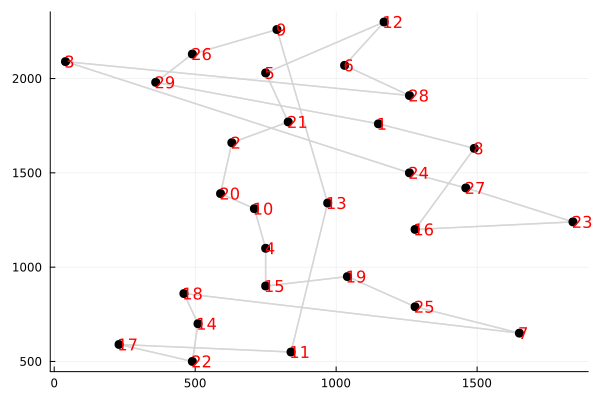

In [39]:
bayg29 = graph_from_tsp("../../instances/stsp/bayg29.tsp","graphe")[1]
@time cycle, nodes_list = semi_optimal_rsl(bayg29,5)
plot_graph(cycle)


Puis on teste recommence en testant sur 20 noeuds : 

Testing with Kruskal
Testing with node :23
Testing with node :4
Testing with node :3
Testing with node :12
Testing with node :11
Testing with node :14
Testing with node :18
Testing with node :19
Testing with node :5
Testing with node :28


Testing with node :10
Testing with node :8
Testing with node :9
Testing with node :7
Testing with node :24
Testing with node :2
Testing with node :13


Testing with node :16
Testing with node :22
Testing with node :21
Testing with node :15
Testing with node :6
Testing with node :20
Testing with node :25
Testing with node :17
Testing with node :27
Testing with node :29


Testing with node :26
Testing with node :1
La meilleure tournée que l'on peut trouver avec RSL est de longueur : 2151.0
Elle est obtenue à l'aide de l'algorithme de Kruskal avec 23 comme racine.
  0.338637 seconds (1.21 M allocations: 67.621 MiB, 13.28% gc time)


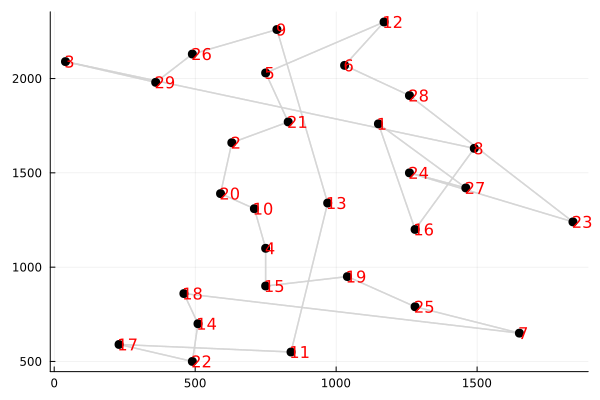

In [38]:
@time cycle, nodes_list = semi_optimal_rsl(bayg29,29)
plot_graph(cycle)

On voit que de tester sur un plus grand nombre de noeuds, même s'ils sont choisis au hasard, augmente les chances de trouver une meilleure solution au problème.

Nous passons maintenant la solution de semi_optimal_rsl à 2-opt. La solution exacte est 1610 pour bayg-29, ce que 2-opt atteint presque.

  0.274320 seconds (213.85 k allocations: 14.028 MiB, 96.90% compilation time)
after two opt: 1693


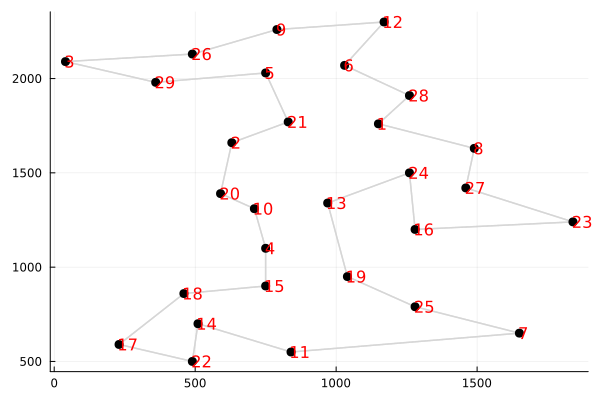

In [40]:
tour_indexes = Vector{Int64}([])
for node in nodes_list
    push!(tour_indexes, index(node))
end
@time two_opt_cycle_graph, two_opt_cycle, two_opt_cost = run_two_opt(bayg29, cycle, tour_indexes)
println("after two opt: ", sum_of_weights(two_opt_cycle_graph))
plot_graph(two_opt_cycle_graph)

### Tests sur les images
On peut tester cette dernières fonction sur différentes images. Nous n'avons laissé 2-opt fonctionner que pendant 3000 itérations. Si nous le faisions tourner avec plus d'itérations, nous pourrions améliorer encore nos solutions.Voici les résultats : 

In [8]:
#shuffled_image_to_reconstruct("instances/tsp/instances/alaska-railroad.tsp","instances/images/shuffled/alaska-railroad.png","Train")

Pour alaska-railroad.png, on obtient une tournée de longueur 8105892 et les images suivantes

L'image originale  :
![title](../../instances/images/original/alaska-railroad.png)


Et l'image reconstruite : 
![title](../../Train-reconstruit.png)



Vous trouverez ci-dessous notre reconstitution de tokyo-skytree-aerial.png. Nous voyons que rsl a un coût de 3.546594e7 et nous obtenons un coût de 14457260 après 2-opt

In [9]:
#@time shuffled_image_to_reconstruct("../../instances/tsp/instances/tokyo-skytree-aerial.tsp","../../instances/images/shuffled/tokyo-skytree-aerial.png","Tokyo")

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓
Calculating a tour


Testing with Prim
Testing with node :26
Testing with node :

195


Testing with node :52
Testing with node :

296


Testing with node :394
La meilleure tournée que l'on peut trouver avec RSL est de longueur : 

3.546594e7
Elle est obtenue à l'aide de l'algorithme de Prim avec 394 comme racine.
rsl finished with cost 3.546594e7
running two opt


317.158844 seconds (1.26 G allocations: 719.017 GiB, 13.83% gc time)
2 opt finished with cost 14457260
531.554838 seconds (5.46 G allocations: 964.527 GiB, 13.56% gc time, 0.09% compilation time: 70% of which was recompilation)

Pour tokyo-skytree-aerial.png, on obtient une tournée de longueur 14457260 et les images suivantes

L'image originale  :
![title](../../instances/images/original/tokyo-skytree-aerial.png)


Et l'image reconstruite : 
![title](Tokyo-reconstruit.png)


In [11]:
#@time shuffled_image_to_reconstruct("../../instances/tsp/instances/marlet2-radio-board.tsp","../../instances/images/shuffled/marlet2-radio-board.png","marlet2", 3, two_opt_iter_stop = 3500)

Reading of header : ✓
Reading of nodes : ✓
Reading of edges : ✓


Calculating a tour


Testing with Prim
Testing with node :193
Testing with node :

433


Testing with node :156
La meilleure tournée que l'on peut trouver avec RSL est de longueur : 

5.6370225e7
Elle est obtenue à l'aide de l'algorithme de Prim avec 156 comme racine.
rsl finished with cost 5.6370225e7
running two opt


865.701785 seconds (2.02 G allocations: 1.278 TiB, 11.62% gc time)
2 opt finished with cost 8863246
1067.222103 seconds (4.54 G allocations: 1.423 TiB, 11.32% gc time)

Voici la reconstitution de l'image marlet2-radio-board.png. Notre coût final avec 2-opt était 8863246.

L'image originale  :
![title](../../instances/images/original/marlet2-radio-board.png)


Et l'image reconstruite : 
![title](marlet2-reconstruit.png)